### This is a new version of MLEAP scripts, started in late Aug 2022.
It will combine IProject_MLEAP_ANN and IP_MLEAP script, while improving them.

#### Outline

1. Load libraries and data.
2. pEDA. Look at feature distribution, fix them if they do not look right.
3. Train-test split. Most likely couple years into test set. 2015-2018?. Impute missing values.
4. Transform numerical features, add ohe for inds.
5. Fit xgb as a baseline, then xgb optuna.
6. Fit DL.



In [38]:
# 0. Import libraries #

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import os, time, math, re, warnings, random, gc, dill, optuna, pickle, shap
import statsmodels.api as sm
from random import sample

from sklearn.model_selection import train_test_split, KFold, PredefinedSplit
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNetCV
from sklearn.preprocessing import LabelBinarizer, LabelEncoder, OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.inspection import permutation_importance
from category_encoders import MEstimateEncoder
from xgboost import XGBRegressor
from optuna.integration import TFKerasPruningCallback
from optuna.trial import TrialState

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers

plt.style.use('seaborn-white')
warnings.simplefilter(action='ignore')
pd.set_option('display.max_columns', 110)
gc.enable()

In [39]:
### target encoding ###
# source: https://www.kaggle.com/code/ryanholbrook/feature-engineering-for-house-prices/notebook

class CrossFoldEncoder:
    def __init__(self, encoder, **kwargs):
        self.encoder_ = encoder
        self.kwargs_ = kwargs  # keyword arguments for the encoder
        self.cv_ = KFold(n_splits=4)

    # Fit an encoder on one split and transform the feature on the
    # other. Iterating over the splits in all folds gives a complete
    # transformation. We also now have one trained encoder on each
    # fold.
    def fit_transform(self, X, y, cols):
        self.fitted_encoders_ = []
        self.cols_ = cols
        X_encoded = []
        for idx_encode, idx_train in self.cv_.split(X):
            fitted_encoder = self.encoder_(cols=cols, **self.kwargs_)
            fitted_encoder.fit(
                X.iloc[idx_encode, :], y.iloc[idx_encode],
            )
            X_encoded.append(fitted_encoder.transform(X.iloc[idx_train, :])[cols])
            self.fitted_encoders_.append(fitted_encoder)
        X_encoded = pd.concat(X_encoded)
        X_encoded.columns = [name + "_encoded" for name in X_encoded.columns]
        return X_encoded

    # To transform the test data, average the encodings learned from
    # each fold.
    def transform(self, X):
        from functools import reduce

        X_encoded_list = []
        for fitted_encoder in self.fitted_encoders_:
            X_encoded = fitted_encoder.transform(X)
            X_encoded_list.append(X_encoded[self.cols_])
        X_encoded = reduce(
            lambda x, y: x.add(y, fill_value=0), X_encoded_list
        ) / len(X_encoded_list)
        X_encoded.columns = [name + "_encoded" for name in X_encoded.columns]
        return X_encoded

In [40]:
# Detect TPU, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver() 
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() 

print("REPLICAS: ", strategy.num_replicas_in_sync)

REPLICAS:  1


In [41]:
#min_prd_list = range(100, 676, 25)
min_prd_list = [250]
# min_prd_list = [150, 250, 350, 450, 550, 650]
#min_prd = min_prd_list[0]
windows_width = 3*12
cv_regularizer=0.2
optuna_trials = 20
time0 = time.time()

results = pd.DataFrame(columns = ['min_prd', 'xgbf_train', 'xgbf_val', 'xgbf_test', 
                                  'xgbgs_train', 'xgbgs_val', 'xgbgs_test', 
                                  'xgbo_train', 'xgbo_val', 'xgbo_test',
                                  'nn2_train', 'nn2_val', 'nn2_test',
                                  'nn4_train', 'nn4_val', 'nn4_test',
                                 'nn6_train', 'nn6_val', 'nn6_test',
                                 'nn4opt_train', 'nn4opt_val', 'nn4opt_test'])
results.min_prd = min_prd_list

for min_prd in min_prd_list:

    with open('../input/mleap-46-preprocessed/MLEAP_46_v7.pkl', 'rb') as pickled_one:
        df = pickle.load(pickled_one)
    df = df[df.prd.isin(range(min_prd-1, min_prd+windows_width+10))]
    df_cnt = df.count()
    empty_cols = list(df_cnt[df_cnt<int(df.shape[0]/2)].index)
    df.drop(columns=empty_cols, inplace=True)
    #display(df.shape, df.head(), df.year.describe(), df.count())

    features_miss_dummies = ['amhd', 'BAspr']
    for col in features_miss_dummies:
        if col in df.columns:
            df[col+'_miss'] = df[col].isnull().astype(int)

    temp_cols = ['PERMNO', 'year', 'prd']
    df.reset_index(inplace=True, drop=True)
    X = df.copy()
    y = X.pop('RET')

    train_indx = X.prd<(min_prd+windows_width-1)
    val_indx = X['prd'].isin(range(min_prd+windows_width-1, min_prd+windows_width+2))
    val_indx_extra = X['prd'].isin(range(min_prd+windows_width+5, min_prd+windows_width+8))
    test_indx = X['prd'].isin(range(min_prd+windows_width+2, min_prd+windows_width+5))

    X_train = X[train_indx]
    X_val = X[val_indx]
    X_val_extra = X[val_indx_extra]
    X_test = X[test_indx]
    y_train = y[train_indx]
    y_val = y[val_indx]
    y_val_extra = y[val_indx_extra]
    y_test = y[test_indx]

    #display(X_train.head(3), X_train.tail(3), y_train.head(3), y_train.tail(3))
    display(X_train.shape, X_val.shape, X_test.shape, X_train.prd.describe(), X_val.prd.describe(), X_test.prd.describe())

    X_train.drop(columns=temp_cols, inplace=True)
    X_val.drop(columns=temp_cols, inplace=True)
    X_val_extra.drop(columns=temp_cols, inplace=True)
    X_test.drop(columns=temp_cols, inplace=True)

    #display(X_train.tail())
    col_cat = ['ind']
    col_num = [x for x in X_train.columns if x not in col_cat]
    for col in col_num:
        X_train[col] = X_train[col].fillna(X_train[col].median())
        X_val[col] = X_val[col].fillna(X_train[col].median())
        X_val_extra[col] = X_val_extra[col].fillna(X_train[col].median())
        X_test[col] = X_test[col].fillna(X_train[col].median())
    for col in col_cat:
        X_train[col] = X_train[col].fillna(value=-1000)
        X_val[col] = X_val[col].fillna(value=-1000)
        X_val_extra[col] = X_val_extra[col].fillna(value=-1000)
        X_test[col] = X_test[col].fillna(value=-1000)

    #display(X_train.tail())
    feature_transformer = ColumnTransformer([('num', StandardScaler(), col_num),
                                            ("cat", OneHotEncoder(sparse = False, handle_unknown="ignore", drop='if_binary'), col_cat)], 
                                            remainder="passthrough")

    print('Number of features before transformation: ', X_train.shape)
    train_index, val_index, val_index_extra, test_index = X_train.index, X_val.index, X_val_extra.index, X_test.index
    X_train = pd.DataFrame(feature_transformer.fit_transform(X_train), columns=feature_transformer.get_feature_names_out())
    X_val = pd.DataFrame(feature_transformer.transform(X_val), columns=feature_transformer.get_feature_names_out())
    X_val_extra = pd.DataFrame(feature_transformer.transform(X_val_extra), columns=feature_transformer.get_feature_names_out())
    X_test = pd.DataFrame(feature_transformer.transform(X_test), columns=feature_transformer.get_feature_names_out())
    print('time to do feature proprocessing: ')
    print('Number of features after transformation: ', X_train.shape, X_val.shape, X_val_extra.shape, X_test.shape)
    X_train.index = train_index
    X_val.index = val_index
    X_val_extra.index = val_index_extra
    X_test.index = test_index
    #display(X_train.tail())

    X = pd.concat([X_train, X_val])
    y = pd.concat([y_train, y_val])
    #display(X,y)

    X_ = pd.concat([X_train, X_val, X_val_extra])
    y_ = pd.concat([y_train, y_val, y_val_extra])
    #display(X,y, X_,y_)

    print('mae of a constant model', mean_absolute_error(df.RET, np.ones(df.shape[0])*(df.RET.mean())))
    print('R2 of a constant model', r2_score(df.RET, np.ones(df.shape[0])*(df.RET.mean())))

    xgb1 = XGBRegressor(tree_method = 'gpu_hist', n_estimators=400, max_depth=4, eta=0.02, colsample_bytree=0.4, subsample=0.6)
    xgb1.fit(X_train, y_train)
    print('fixed XGB train:', mean_absolute_error(y_train, xgb1.predict(X_train)), r2_score(y_train, xgb1.predict(X_train)))
    print('XGB val:', mean_absolute_error(y_val, xgb1.predict(X_val)), r2_score(y_val, xgb1.predict(X_val)))
    print('XGB val extra:', mean_absolute_error(y_val_extra, xgb1.predict(X_val_extra)), r2_score(y_val_extra, xgb1.predict(X_val_extra)))
    print('XGB test:', mean_absolute_error(y_test, xgb1.predict(X_test)), r2_score(y_test, xgb1.predict(X_test)))

    results.loc[results.min_prd==min_prd,'xgbf_train':'xgbf_test'] = \
    [r2_score(y_train, xgb1.predict(X_train)), 
    r2_score(y_val, xgb1.predict(X_val)),
    r2_score(y_test, xgb1.predict(X_test))]

    time1 = time.time()

    # Create a list where train data indices are -1 and validation data indices are 0
    split_index = [-1 if x in X_train.index else 0 for x in X.index]
    pds = PredefinedSplit(test_fold = split_index)

    xgb = XGBRegressor(tree_method = 'gpu_hist')
    param_grid = {'n_estimators':[400, 600, 800], 'max_depth':[2,3,4,5], 'eta':[0.006, 0.012, 0.02], 
                  'subsample':[0.6], 'colsample_bytree':[0.6]}
    xgbgs = GridSearchCV(estimator = xgb, cv=pds, param_grid=param_grid)

    # Fit with all data
    xgbgs.fit(X_, y_)

    print('gs XGB', xgbgs.best_params_, xgbgs.best_score_, time.time()-time1)
    print('XGB train:', mean_absolute_error(y_train, xgbgs.predict(X_train)), r2_score(y_train, xgbgs.predict(X_train)))
    print('XGB validation:', mean_absolute_error(y_val, xgbgs.predict(X_val)), r2_score(y_val, xgbgs.predict(X_val)))
    print('XGB validation extra:', mean_absolute_error(y_val_extra, xgbgs.predict(X_val_extra)), r2_score(y_val_extra, xgbgs.predict(X_val_extra)))
    print('XGB test:', mean_absolute_error(y_test, xgbgs.predict(X_test)), r2_score(y_test, xgbgs.predict(X_test)))

    results.loc[results.min_prd==min_prd,'xgbgs_train':'xgbgs_test'] = \
    [r2_score(y_train, xgbgs.predict(X_train)), 
    r2_score(y_val, xgbgs.predict(X_val)),
    r2_score(y_test, xgbgs.predict(X_test))]

    time1 = time.time()
    def objective(trial, cv_runs=1, n_splits=2, n_jobs=-1):

        params = {
        "tree_method": 'gpu_hist',
        "verbosity": 0,  # 0 (silent) - 3 (debug)
        "n_estimators": trial.suggest_int("n_estimators", 800, 1500),
        "max_depth": trial.suggest_int("max_depth", 2, 6),
        "learning_rate": trial.suggest_uniform("learning_rate", 0.0005, 0.03),
        "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.05, 0.95),
        "subsample": trial.suggest_uniform("subsample", 0.1, 0.95),
        "alpha": trial.suggest_loguniform("alpha", 0.1, 50.0),
        "lambda": trial.suggest_loguniform("lambda", 0.1, 500.0),
        "gamma": trial.suggest_loguniform("gamma", 1e-10, 100.0),
        "min_child_weight": trial.suggest_loguniform("min_child_weight", 0.1, 50)    }

        model = XGBRegressor(**params, njobs=-1)
        model.fit(X_train, y_train, eval_set=[(X_val, y_val)], early_stopping_rounds=50, verbose = False)

        score_train = r2_score(y_train, model.predict(X_train))
        score_val = r2_score(y_val, model.predict(X_val))
        score_val_extra = r2_score(y_val_extra, model.predict(X_val_extra)) 
        score_val = (score_val+score_val_extra)/2
        overfit = np.abs(score_train-score_val)

        return score_val-cv_regularizer*overfit


    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=optuna_trials)
    print('Total time for hypermarameter optimization ', time.time()-time1)
    hp = study.best_params
    for key, value in hp.items():
        print(f"{key:>20s} : {value}")
    print(f"{'best objective value':>20s} : {study.best_value}")
    optuna_hyperpars = study.best_params
    optuna_hyperpars['tree_method']='gpu_hist'
    optuna_xgb = XGBRegressor(**optuna_hyperpars)
    optuna_xgb.fit(X, y)
    print('Optuna XGB train: \n', 
          mean_absolute_error(y_train, optuna_xgb.predict(X_train)), r2_score(y_train, optuna_xgb.predict(X_train)), '\nvalidation \n',
          mean_absolute_error(y_val, optuna_xgb.predict(X_val)), r2_score(y_val, optuna_xgb.predict(X_val)),
          mean_absolute_error(y_val_extra, optuna_xgb.predict(X_val_extra)), r2_score(y_val_extra, optuna_xgb.predict(X_val_extra)), '\ntest \n',
          mean_absolute_error(y_test, optuna_xgb.predict(X_test)), r2_score(y_test, optuna_xgb.predict(X_test)))

    results.loc[results.min_prd==min_prd,'xgbo_train':'xgbo_test'] = \
    [r2_score(y_train, optuna_xgb.predict(X_train)), 
    r2_score(y_val, optuna_xgb.predict(X_val)),
    r2_score(y_test, optuna_xgb.predict(X_test))]

    display(results)

(79162, 41)

(6405, 41)

(6311, 41)

count    79162.000000
mean       266.337409
std         10.396123
min        249.000000
25%        257.000000
50%        266.000000
75%        275.000000
max        284.000000
Name: prd, dtype: float64

count    6405.000000
mean      285.996565
std         0.816362
min       285.000000
25%       285.000000
50%       286.000000
75%       287.000000
max       287.000000
Name: prd, dtype: float64

count    6311.000000
mean      288.997782
std         0.816235
min       288.000000
25%       288.000000
50%       289.000000
75%       290.000000
max       290.000000
Name: prd, dtype: float64

Number of features before transformation:  (79162, 38)
time to do feature proprocessing: 
Number of features after transformation:  (79162, 85) (6405, 85) (6616, 85) (6311, 85)
mae of a constant model 8.616058689352922
R2 of a constant model 0.0
fixed XGB train: 8.094503280537975 0.08807399835850738
XGB val: 7.80268307196985 -0.012211276662149384
XGB val extra: 9.182509786895938 0.006809524790626353
XGB test: 7.84572645024662 0.015254350212336232
gs XGB {'colsample_bytree': 0.6, 'eta': 0.006, 'max_depth': 5, 'n_estimators': 400, 'subsample': 0.6} -0.009211110247068666 60.569270849227905
XGB train: 8.232025093474888 0.060695330008433745
XGB validation: 7.630334731974988 0.032497740585895496
XGB validation extra: 8.985427732621966 0.05388213675932696
XGB test: 7.787969462570123 0.02523901836111997


[I 2022-09-07 22:35:28,267] A new study created in memory with name: no-name-a6e1b7f6-8576-4042-95e5-d5b1ab0c3286
[I 2022-09-07 22:35:28,828] Trial 0 finished with value: -0.0008816729938491586 and parameters: {'n_estimators': 894, 'max_depth': 4, 'learning_rate': 0.015206125102708551, 'colsample_bytree': 0.727472546044549, 'subsample': 0.6668762422959155, 'alpha': 0.16416213505025606, 'lambda': 12.56758675311284, 'gamma': 3.204357162403921e-09, 'min_child_weight': 0.3314894959099506}. Best is trial 0 with value: -0.0008816729938491586.
[I 2022-09-07 22:35:29,557] Trial 1 finished with value: -0.0016583137822383965 and parameters: {'n_estimators': 946, 'max_depth': 6, 'learning_rate': 0.024073180210942676, 'colsample_bytree': 0.48685284397349404, 'subsample': 0.6122056106144049, 'alpha': 20.752350789283017, 'lambda': 25.230960398905292, 'gamma': 0.002993538161822937, 'min_child_weight': 6.92249138554978}. Best is trial 0 with value: -0.0008816729938491586.
[I 2022-09-07 22:35:30,147] T

Total time for hypermarameter optimization  13.31822657585144
        n_estimators : 1208
           max_depth : 3
       learning_rate : 0.019786911116601975
    colsample_bytree : 0.07988606282743463
           subsample : 0.1067523635186749
               alpha : 3.0956688909432075
              lambda : 1.0910923027497512
               gamma : 1.7575509481409663e-06
    min_child_weight : 1.0781819255594691
best objective value : 0.0008273389493137495
Optuna XGB train: 
 8.131424920349795 0.07986569966974155 
validation 
 7.673552230268689 0.026530136812708216 9.132102095448861 0.01834595767477354 
test 
 7.79042347026519 0.027897881814417325


,min_prd,xgbf_train,xgbf_val,xgbf_test,xgbgs_train,xgbgs_val,xgbgs_test,xgbo_train,xgbo_val,xgbo_test,nn4_train,nn4_val,nn4_test,nn4opt_train,nn4opt_val,nn4opt_test
0,250,0.088074,-0.012211,0.015254,0.060695,0.032498,0.025239,0.079866,0.02653,0.027898,NaN,NaN,NaN,NaN,NaN,NaN


In [42]:
display(results.iloc[:,1:].mean())
# cv_regularizer = 0.5
# optuna_trials = 80
print(time.time()-time0)

xgbf_train      0.088074
xgbf_val       -0.012211
xgbf_test       0.015254
xgbgs_train     0.060695
xgbgs_val       0.032498
xgbgs_test      0.025239
xgbo_train      0.079866
xgbo_val        0.026530
xgbo_test       0.027898
nn4_train            NaN
nn4_val              NaN
nn4_test             NaN
nn4opt_train         NaN
nn4opt_val           NaN
nn4opt_test          NaN
dtype: float64

85.89697074890137


In [43]:
# general point:
# compared to NN, xgb is harder to regularize
# in NN, you can simply shrink coefficient towards constant prediction.
# in xgb, you can not do that. the only way to regularize is via hyperparameters.
# in other words, by tweaking hyperpars, in NN you can approach R^2=0.0 prediction from a constant model arbitrarily close
# in xgb, you can not do that.
# by setting eta as low as 0.1% you can bring r2 down to 0.1%, but lowering eta further actyally increases abs(r2).


In [44]:
optuna_xgb

XGBRegressor(alpha=3.0956688909432075, base_score=0.5, booster='gbtree',
             callbacks=None, colsample_bylevel=1, colsample_bynode=1,
             colsample_bytree=0.07988606282743463, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None,
             gamma=1.7575509481409663e-06, gpu_id=0, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             lambda=1.0910923027497512, learning_rate=0.019786911116601975,
             max_bin=256, max_cat_to_onehot=4, max_delta_step=0, max_depth=3,
             max_leaves=0, min_child_weight=1.0781819255594691, missing=nan,
             monotone_constraints='()', n_estimators=1208, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, ...)

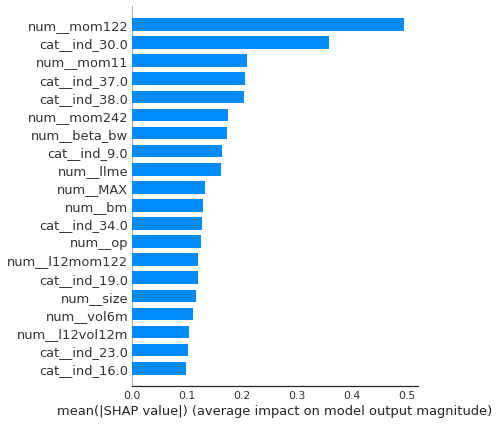

In [45]:
explainerxgbc = shap.TreeExplainer(optuna_xgb)
shap_values_XGBoost_test = explainerxgbc.shap_values(X_test)

vals = np.abs(shap_values_XGBoost_test).mean(0)
feature_names = X_test.columns
feature_importance = pd.DataFrame(list(zip(feature_names, vals)),
                                 columns=['col_name','feature_importance_vals'])
feature_importance.sort_values(by=['feature_importance_vals'],
                              ascending=False, inplace=True)

shap.summary_plot(shap_values_XGBoost_test, X_test, 
                  plot_type="bar", plot_size=(6,6), max_display=20)

In [46]:
# Evaluate performance of XGB models:
r2_xgb1 = r2_score(y_test, xgb1.predict(X_test))
r2_xgbgs = r2_score(y_test, xgbgs.predict(X_test))
r2_xgbo = r2_score(y_test, optuna_xgb.predict(X_test))

print('Min_prd: ', min_prd)
print('Constant guess: ', mean_absolute_error(y_test, np.ones(len(y_test))*y_test.mean()), 
      r2_score(y_test, np.ones(len(y_test))*y_test.mean()))
print('XGB test:', mean_absolute_error(y_test, xgb1.predict(X_test)), r2_xgb1)
print('XGB GS test:', mean_absolute_error(y_test, xgbgs.predict(X_test)), r2_xgbgs)
print('Optuna XGB test:', mean_absolute_error(y_test, optuna_xgb.predict(X_test)), r2_xgbo)


Min_prd:  250
Constant guess:  7.924561381034317 0.0
XGB test: 7.84572645024662 0.015254350212336232
XGB GS test: 7.787969462570123 0.02523901836111997
Optuna XGB test: 7.79042347026519 0.027897881814417325


In [47]:
print('Total time for a script: ', time.time()-time0)

Total time for a script:  87.07501125335693


In [48]:
results.iloc[:,1:].mean()

xgbf_train      0.088074
xgbf_val       -0.012211
xgbf_test       0.015254
xgbgs_train     0.060695
xgbgs_val       0.032498
xgbgs_test      0.025239
xgbo_train      0.079866
xgbo_val        0.026530
xgbo_test       0.027898
nn4_train            NaN
nn4_val              NaN
nn4_test             NaN
nn4opt_train         NaN
nn4opt_val           NaN
nn4opt_test          NaN
dtype: float64

In [49]:
# 3yr window, trials=20, cv_reg=0.03: 0.88%. runs 1 hr.
# 3yr, t=40, cv_reg=0.04: 0.96%.



In [50]:
display(X_train, X_val, X_test)

,num__mom482,num__mom242,num__bm,num__op,num__gp,num__inv,num__mom11,num__mom122,num__amhd,num__ivol_capm,num__ivol_ff5,num__beta_bw,num__MAX,num__vol1m,num__vol6m,num__vol12m,num__size,num__lbm,num__lop,num__lgp,num__linv,num__llme,num__l1amhd,num__l1MAX,num__l3amhd,num__l3MAX,num__l6amhd,num__l6MAX,num__l12amhd,num__l12MAX,num__l12mom122,num__l12ivol_capm,num__l12ivol_ff5,num__l12beta_bw,num__l12vol6m,num__l12vol12m,num__amhd_miss,cat__ind_1.0,cat__ind_2.0,cat__ind_3.0,cat__ind_4.0,cat__ind_5.0,cat__ind_6.0,cat__ind_7.0,cat__ind_8.0,cat__ind_9.0,cat__ind_10.0,cat__ind_11.0,cat__ind_12.0,cat__ind_13.0,cat__ind_14.0,cat__ind_15.0,cat__ind_16.0,cat__ind_17.0,cat__ind_18.0,cat__ind_19.0,cat__ind_20.0,cat__ind_21.0,cat__ind_22.0,cat__ind_23.0,cat__ind_24.0,cat__ind_25.0,cat__ind_26.0,cat__ind_27.0,cat__ind_28.0,cat__ind_29.0,cat__ind_30.0,cat__ind_31.0,cat__ind_32.0,cat__ind_33.0,cat__ind_34.0,cat__ind_35.0,cat__ind_36.0,cat__ind_37.0,cat__ind_38.0,cat__ind_39.0,cat__ind_40.0,cat__ind_41.0,cat__ind_42.0,cat__ind_43.0,cat__ind_44.0,cat__ind_45.0,cat__ind_47.0,cat__ind_48.0,cat__ind_49.0
0,-0.574564,-0.711081,0.472308,-0.134353,-1.129718,-0.392313,-0.291318,-0.566625,-0.711182,-0.877729,-0.777803,-0.290435,-0.729070,-0.931525,-1.013542,-1.142541,0.884642,0.282772,-0.127991,-1.106961,-0.536405,1.046549,-0.767426,-0.752765,-0.691502,-1.055559,-0.712044,-0.801846,-0.793977,-0.752765,-0.449638,-0.884437,-0.928455,-0.039010,-1.128689,-1.198377,-0.850499,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.653236,-0.688240,0.472308,-0.134353,-1.129718,-0.392313,-0.256761,-0.281055,-0.725324,-0.863874,-0.841188,-0.390012,-0.914071,-0.929305,-1.037940,-1.204140,0.878183,0.282772,-0.127991,-1.106961,-0.536405,0.976333,-0.720364,-0.738622,-0.729562,-0.627579,-0.666427,-0.880118,-0.766839,-0.738622,-0.432148,-0.441625,-0.316339,0.071654,-1.100925,-1.122707,-0.850499,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.590031,-0.689546,0.472308,-0.134353,-1.129718,-0.392313,-0.247274,-0.277685,-0.762064,-1.125174,-1.126674,-0.400091,-0.890002,-1.089513,-1.077085,-1.203867,0.862794,0.282772,-0.127991,-1.106961,-0.536405,0.958378,-0.734527,-0.921749,-0.788583,-0.745667,-0.697685,-0.599916,-0.750813,-0.921749,-0.711138,-1.087944,-1.068946,0.105760,-1.085436,-1.158464,-0.850499,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.457370,-0.638779,0.472308,-0.134353,-1.129718,-0.392313,0.597571,-0.412356,-0.772104,-0.658278,-0.636945,-0.308280,-0.563560,-0.640612,-1.025729,-1.160449,0.905620,0.282772,-0.127991,-1.106961,-0.536405,0.978536,-0.771321,-0.897924,-0.741403,-0.731403,-0.730937,-1.069933,-0.744892,-0.897924,-0.761080,-0.969431,-0.923707,0.116068,-1.079960,-1.170898,-0.850499,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.604114,-0.623601,0.472308,-0.134353,-1.129718,-0.392313,0.539864,-0.469925,-0.767163,-0.716880,-0.679172,-0.284042,-0.580173,-0.749459,-1.060253,-1.159392,0.945342,0.282772,-0.127991,-1.106961,-0.536405,1.032828,-0.781376,-0.574787,-0.755602,-0.916098,-0.769223,-0.643464,-0.751251,-0.574787,-0.791735,-0.734650,-0.897763,-0.004421,-1.041669,-1.155515,-0.850499,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,.

,num__mom482,num__mom242,num__bm,num__op,num__gp,num__inv,num__mom11,num__mom122,num__amhd,num__ivol_capm,num__ivol_ff5,num__beta_bw,num__MAX,num__vol1m,num__vol6m,num__vol12m,num__size,num__lbm,num__lop,num__lgp,num__linv,num__llme,num__l1amhd,num__l1MAX,num__l3amhd,num__l3MAX,num__l6amhd,num__l6MAX,num__l12amhd,num__l12MAX,num__l12mom122,num__l12ivol_capm,num__l12ivol_ff5,num__l12beta_bw,num__l12vol6m,num__l12vol12m,num__amhd_miss,cat__ind_1.0,cat__ind_2.0,cat__ind_3.0,cat__ind_4.0,cat__ind_5.0,cat__ind_6.0,cat__ind_7.0,cat__ind_8.0,cat__ind_9.0,cat__ind_10.0,cat__ind_11.0,cat__ind_12.0,cat__ind_13.0,cat__ind_14.0,cat__ind_15.0,cat__ind_16.0,cat__ind_17.0,cat__ind_18.0,cat__ind_19.0,cat__ind_20.0,cat__ind_21.0,cat__ind_22.0,cat__ind_23.0,cat__ind_24.0,cat__ind_25.0,cat__ind_26.0,cat__ind_27.0,cat__ind_28.0,cat__ind_29.0,cat__ind_30.0,cat__ind_31.0,cat__ind_32.0,cat__ind_33.0,cat__ind_34.0,cat__ind_35.0,cat__ind_36.0,cat__ind_37.0,cat__ind_38.0,cat__ind_39.0,cat__ind_40.0,cat__ind_41.0,cat__ind_42.0,cat__ind_43.0,cat__ind_44.0,cat__ind_45.0,cat__ind_47.0,cat__ind_48.0,cat__ind_49.0
36,-0.585324,-0.644216,0.379757,-0.197630,-1.066823,-0.365342,0.388211,-0.899505,-1.038144,-0.560815,-0.445949,-0.416552,-0.303738,-0.659472,-0.982810,-1.166545,1.057885,0.654601,-0.320691,-1.112279,-0.276956,1.216944,-1.089773,-0.902409,-1.187112,-0.977416,-1.333498,-0.924382,-1.189411,-0.902409,0.539004,-0.589160,-0.613450,0.138360,-0.773293,-0.616222,-0.850499,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
37,-0.726781,-0.772511,0.379757,-0.197630,-1.066823,-0.365342,-0.990431,-0.984266,-0.984656,-0.393243,-0.315458,-0.244301,-0.295420,-0.124462,-0.839646,-1.104340,1.005449,0.654601,-0.320691,-1.112279,-0.276956,1.272056,-1.047810,-0.317597,-1.150335,-0.484600,-1.303997,-0.450954,-1.195741,-0.317597,-0.186181,-0.615879,-0.481990,0.060410,-0.744144,-0.643334,-0.850499,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
38,-0.719618,-0.431708,0.379757,-0.197630,-1.066823,-0.365342,-0.162117,-1.126915,-0.964176,-0.979260,-0.866734,-0.289412,-0.906472,-0.742458,-0.828203,-1.116244,1.005449,0.654601,-0.320691,-1.112279,-0.276956,1.260143,-0.994242,-0.309362,-1.111737,-0.896592,-1.309644,-1.069933,-1.210686,-0.309362,0.331343,-0.885376,-1.056955,0.024423,-0.842861,-0.659589,-0.850499,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
83,-0.303435,-1.207074,0.139332,-0.120186,-0.301792,0.217784,0.398875,-1.046352,0.301660,0.074126,0.016825,-0.417008,0.411358,-0.015756,-0.663543,-0.590345,0.318093,-0.045407,0.416153,-0.030640,0.230781,0.503442,0.282370,-0.546595,0.196414,-0.252899,-0.010498,-0.775373,0.086514,-0.546595,-0.519835,0.360269,0.421111,-0.446306,0.136028,-0.091275,-0.850499,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
84,-0.380104,-1.020176,0.139332,-0.120186,-0.301792,0.217784,0.633951,-0.901490,0.324640,0.380243,0.591793,-0.650563,0.690118,0.252041,-0.472592,-0.656507,0.362862,-0.045407,0.416153,-0.030640,0.230781,0.498180,0.293974,0.390257,0.240561,-0.466554,0.052464,-0.501467,0.075144,0.390257,-1.119754,0.484527,0.439798,-0.325219,0.270547,0.027074,-0.850499,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,

,num__mom482,num__mom242,num__bm,num__op,num__gp,num__inv,num__mom11,num__mom122,num__amhd,num__ivol_capm,num__ivol_ff5,num__beta_bw,num__MAX,num__vol1m,num__vol6m,num__vol12m,num__size,num__lbm,num__lop,num__lgp,num__linv,num__llme,num__l1amhd,num__l1MAX,num__l3amhd,num__l3MAX,num__l6amhd,num__l6MAX,num__l12amhd,num__l12MAX,num__l12mom122,num__l12ivol_capm,num__l12ivol_ff5,num__l12beta_bw,num__l12vol6m,num__l12vol12m,num__amhd_miss,cat__ind_1.0,cat__ind_2.0,cat__ind_3.0,cat__ind_4.0,cat__ind_5.0,cat__ind_6.0,cat__ind_7.0,cat__ind_8.0,cat__ind_9.0,cat__ind_10.0,cat__ind_11.0,cat__ind_12.0,cat__ind_13.0,cat__ind_14.0,cat__ind_15.0,cat__ind_16.0,cat__ind_17.0,cat__ind_18.0,cat__ind_19.0,cat__ind_20.0,cat__ind_21.0,cat__ind_22.0,cat__ind_23.0,cat__ind_24.0,cat__ind_25.0,cat__ind_26.0,cat__ind_27.0,cat__ind_28.0,cat__ind_29.0,cat__ind_30.0,cat__ind_31.0,cat__ind_32.0,cat__ind_33.0,cat__ind_34.0,cat__ind_35.0,cat__ind_36.0,cat__ind_37.0,cat__ind_38.0,cat__ind_39.0,cat__ind_40.0,cat__ind_41.0,cat__ind_42.0,cat__ind_43.0,cat__ind_44.0,cat__ind_45.0,cat__ind_47.0,cat__ind_48.0,cat__ind_49.0
39,-0.867368,-0.499066,0.379757,-0.197630,-1.066823,-0.365342,-0.719913,-1.112204,-0.951812,-0.823485,-0.823200,-0.263365,-0.847810,-0.759358,-0.939433,-1.113617,0.960933,0.654601,-0.320691,-1.112279,-0.276956,1.250689,-0.973732,-0.914227,-1.069669,-0.306774,-1.229480,-0.992066,-1.251140,-0.914227,0.966894,-0.782169,-0.887040,-0.205925,-0.916214,-0.819440,-0.850499,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
40,-0.813073,-0.496274,0.379757,-0.197630,-1.066823,-0.365342,0.469989,-1.102434,-0.895303,-0.483593,-0.413036,-0.226876,-0.565454,-0.561918,-0.899538,-1.067529,0.998287,0.654601,-0.320691,-1.112279,-0.276956,1.214034,-0.961350,-0.856158,-1.015967,-0.298469,-1.192486,-0.500990,-1.317560,-0.856158,1.063903,-0.936993,-0.912128,-0.326780,-0.911090,-0.921379,-0.850499,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
41,-0.929999,-0.655791,0.379757,-0.197630,-1.066823,-0.365342,-0.795177,-1.090620,-0.873778,-0.981461,-0.907385,-0.229098,-0.911075,-1.073475,-0.913637,-1.073300,0.949190,0.654601,-0.320691,-1.112279,-0.276956,1.241065,-0.904757,-0.576662,-0.995405,-0.908511,-1.153659,-0.911528,-1.374790,-0.576662,0.470431,-1.003227,-1.016788,-0.395446,-1.059311,-0.963268,-0.850499,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
86,-0.653287,-0.592435,0.139332,-0.120186,-0.301792,0.217784,-0.368547,-0.800143,0.278860,-0.656207,-0.539955,-0.640559,-0.583769,-0.865856,-0.558238,-0.730289,0.327357,-0.045407,0.416153,-0.030640,0.230781,0.499802,0.281703,-0.862803,0.275475,0.407140,0.162234,-0.270107,0.109854,-0.862803,-0.407803,-0.389782,-0.263555,-0.248717,0.162718,0.044085,-0.850499,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
87,-0.774069,-0.803011,0.139332,-0.120186,-0.301792,0.217784,0.220612,-1.037389,0.297423,-0.625074,-0.481491,-0.609086,-0.852556,-0.668448,-0.591883,-0.773978,0.342443,-0.045407,0.416153,-0.030640,0.230781,0.542960,0.271140,-0.594792,0.298546,0.685439,0.206642,-0.483007,0.032981,-0.594792,0.107700,-0.168599,-0.665567,-0.120194,0.042497,-0.044168,-0.850499,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,

In [51]:
neurons_base = 16
dropout_rate = 0.05
# n_b=8 was ok with small overfit.
# n_b=32 starts clearly overfitting. 
# 128 fits clearly slower than 64 and becomes somewhat unstable. regularization could make it work, but i see no reason to go wider.
# 64 seems to have nice balance of flexibility and runtime, but its variance may be too large. dropout makes variance vene worse.
# 6 hidden layers is probably most this architecture can hold

# in this framework the optimal model seems to have width of 16 or 32, somehow regularized. try l1/l2?
# w32 can take at most 0.03 dropout.
# w16 looks good w/o dropout.

# more general point:
# main drawback of dropout is in incresing variance
# for textbook problems with high s/n ratio (e.g., mnist) this may be ok.
# for application like this with very low s/n ratio dropout may be a bad idea.

model_snn = Sequential([
    tf.keras.layers.Dense(units=neurons_base*32, activation="selu", kernel_initializer="lecun_normal", input_shape=X_train.shape[1:]),
    tf.keras.layers.AlphaDropout(dropout_rate),
    tf.keras.layers.Dense(units=neurons_base*16, activation="selu", kernel_initializer="lecun_normal"),
    tf.keras.layers.AlphaDropout(dropout_rate),
    tf.keras.layers.Dense(units=neurons_base*8, activation="selu", kernel_initializer="lecun_normal"),
    tf.keras.layers.AlphaDropout(dropout_rate),
    tf.keras.layers.Dense(units=neurons_base*4, activation="selu", kernel_initializer="lecun_normal"),
    tf.keras.layers.AlphaDropout(dropout_rate),
    tf.keras.layers.Dense(units=neurons_base*2, activation="selu", kernel_initializer="lecun_normal"),
    tf.keras.layers.AlphaDropout(dropout_rate),
    tf.keras.layers.Dense(units=neurons_base, activation="selu", kernel_initializer="lecun_normal"),
    tf.keras.layers.AlphaDropout(dropout_rate),
    Dense(1)])

print(model_snn.count_params())

219137


3801
Epoch 1/1000
39/39 - 1s - loss: 172.9501 - mean_squared_error: 134.9601 - val_loss: 152.9505 - val_mean_squared_error: 120.4947
Epoch 2/1000
39/39 - 0s - loss: 161.9304 - mean_squared_error: 133.5768 - val_loss: 144.9585 - val_mean_squared_error: 120.4769
Epoch 3/1000
39/39 - 0s - loss: 154.4146 - mean_squared_error: 132.7024 - val_loss: 138.9583 - val_mean_squared_error: 119.8463
Epoch 4/1000
39/39 - 0s - loss: 148.6249 - mean_squared_error: 131.2455 - val_loss: 134.2309 - val_mean_squared_error: 118.4327
Epoch 5/1000
39/39 - 0s - loss: 144.1223 - mean_squared_error: 129.4068 - val_loss: 132.5810 - val_mean_squared_error: 119.0128
Epoch 6/1000
39/39 - 0s - loss: 141.0169 - mean_squared_error: 128.4240 - val_loss: 130.7639 - val_mean_squared_error: 119.2306
Epoch 7/1000
39/39 - 0s - loss: 138.8871 - mean_squared_error: 128.1340 - val_loss: 130.6674 - val_mean_squared_error: 120.6683
Epoch 8/1000
39/39 - 0s - loss: 137.4705 - mean_squared_error: 128.1058 - val_loss: 130.3918 - val_

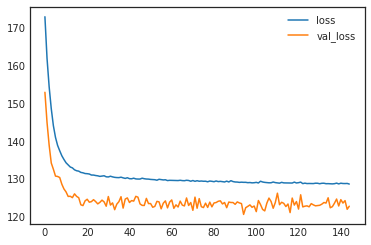

In [62]:
neurons_base = 8
l2_reg_rate = 0.5

model_snn6 = Sequential([
    tf.keras.layers.Dense(units=neurons_base*4, activation="selu", kernel_initializer="lecun_normal", 
                          kernel_regularizer=tf.keras.regularizers.l2(l=l2_reg_rate), input_shape=X_train.shape[1:]),
    tf.keras.layers.Dense(units=neurons_base*2, activation="selu", kernel_initializer="lecun_normal",
                         kernel_regularizer=tf.keras.regularizers.l2(l=l2_reg_rate)),
    tf.keras.layers.Dense(units=neurons_base*2, activation="selu", kernel_initializer="lecun_normal",
                         kernel_regularizer=tf.keras.regularizers.l2(l=l2_reg_rate)),
    tf.keras.layers.Dense(units=neurons_base, activation="selu", kernel_initializer="lecun_normal",
                         kernel_regularizer=tf.keras.regularizers.l2(l=l2_reg_rate)),
    tf.keras.layers.Dense(units=neurons_base, activation="selu", kernel_initializer="lecun_normal",
                         kernel_regularizer=tf.keras.regularizers.l2(l=l2_reg_rate)),
    tf.keras.layers.Dense(units=neurons_base/2, activation="selu", kernel_initializer="lecun_normal",
                         kernel_regularizer=tf.keras.regularizers.l2(l=l2_reg_rate)),
    Dense(1)])

print(model_snn6.count_params())

# snn: 32-16-8-4 with 30%l2 reg seems to converge to 5.1% test r2.

early_stopping50 = EarlyStopping(patience=50, restore_best_weights=True)
optimizer_adam = tf.keras.optimizers.Adam()

model_snn6.compile(loss= "mean_squared_error" , optimizer=optimizer_adam, metrics=["mean_squared_error"])

time1 = time.time()
history = model_snn6.fit(X_train, y_train, validation_data=(X_val, y_val), 
                         batch_size=2048, epochs=1000, verbose=2, callbacks=[early_stopping50])
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()))

print([r2_score(y_train, model_snn6.predict(X_train)), 
       r2_score(y_val, model_snn6.predict(X_val)),
       r2_score(y_test, model_snn6.predict(X_test))])

results.loc[results.min_prd==min_prd,'nn6_train':'nn6_test'] = \
[r2_score(y_train, model_snn6.predict(X_train)), 
r2_score(y_val, model_snn6.predict(X_val)),
r2_score(y_test, model_snn6.predict(X_test))]

print(time.time()-time1)

3025
Epoch 1/1000
39/39 - 1s - loss: 139.1205 - mean_squared_error: 133.0109 - val_loss: 123.3008 - val_mean_squared_error: 120.1529
Epoch 2/1000
39/39 - 0s - loss: 133.0486 - mean_squared_error: 130.2159 - val_loss: 123.3431 - val_mean_squared_error: 120.5700
Epoch 3/1000
39/39 - 0s - loss: 131.3897 - mean_squared_error: 128.6571 - val_loss: 123.5669 - val_mean_squared_error: 121.0117
Epoch 4/1000
39/39 - 0s - loss: 130.8617 - mean_squared_error: 128.3566 - val_loss: 124.4334 - val_mean_squared_error: 122.1009
Epoch 5/1000
39/39 - 0s - loss: 130.2918 - mean_squared_error: 128.0377 - val_loss: 123.0372 - val_mean_squared_error: 120.8692
Epoch 6/1000
39/39 - 0s - loss: 129.8382 - mean_squared_error: 127.6971 - val_loss: 123.7738 - val_mean_squared_error: 121.6488
Epoch 7/1000
39/39 - 0s - loss: 129.7483 - mean_squared_error: 127.6723 - val_loss: 122.2005 - val_mean_squared_error: 120.1767
Epoch 8/1000
39/39 - 0s - loss: 129.4280 - mean_squared_error: 127.4740 - val_loss: 121.0496 - val_

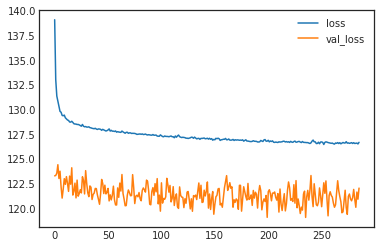

In [63]:
neurons_base = 8
l2_reg_rate = 0.1

model_snn2 = Sequential([
    tf.keras.layers.Dense(units=neurons_base*4, activation="selu", kernel_initializer="lecun_normal", 
                          kernel_regularizer=tf.keras.regularizers.l2(l=l2_reg_rate), input_shape=X_train.shape[1:]),
    tf.keras.layers.Dense(units=neurons_base, activation="selu", kernel_initializer="lecun_normal",
                         kernel_regularizer=tf.keras.regularizers.l2(l=l2_reg_rate)),
    Dense(1)])

print(model_snn2.count_params())

model_snn2.compile(loss= "mean_squared_error" , optimizer=optimizer_adam, metrics=["mean_squared_error"])

time1 = time.time()
history = model_snn2.fit(X_train, y_train, validation_data=(X_val, y_val), 
                         batch_size=2048, epochs=1000, verbose=2, callbacks=[early_stopping50])
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()))

print([r2_score(y_train, model_snn2.predict(X_train)), 
       r2_score(y_val, model_snn2.predict(X_val)),
       r2_score(y_test, model_snn2.predict(X_test))])

results.loc[results.min_prd==min_prd,'nn2_train':'nn2_test'] = \
[r2_score(y_train, model_snn2.predict(X_train)), 
r2_score(y_val, model_snn2.predict(X_val)),
r2_score(y_test, model_snn2.predict(X_test))]

print(time.time()-time1)

3457
Epoch 1/1000
39/39 - 1s - loss: 142.1303 - mean_squared_error: 133.2651 - val_loss: 124.4907 - val_mean_squared_error: 120.3491
Epoch 2/1000
39/39 - 0s - loss: 133.4022 - mean_squared_error: 129.5773 - val_loss: 125.2889 - val_mean_squared_error: 121.8191
Epoch 3/1000
39/39 - 0s - loss: 131.5661 - mean_squared_error: 128.3730 - val_loss: 121.7505 - val_mean_squared_error: 118.8210
Epoch 4/1000
39/39 - 0s - loss: 130.6153 - mean_squared_error: 127.8221 - val_loss: 123.4242 - val_mean_squared_error: 120.7582
Epoch 5/1000
39/39 - 0s - loss: 130.0938 - mean_squared_error: 127.5187 - val_loss: 122.2634 - val_mean_squared_error: 119.8083
Epoch 6/1000
39/39 - 0s - loss: 130.0591 - mean_squared_error: 127.6683 - val_loss: 122.2936 - val_mean_squared_error: 119.9857
Epoch 7/1000
39/39 - 0s - loss: 130.0103 - mean_squared_error: 127.6862 - val_loss: 124.3109 - val_mean_squared_error: 122.0224
Epoch 8/1000
39/39 - 0s - loss: 129.4843 - mean_squared_error: 127.1737 - val_loss: 123.1898 - val_

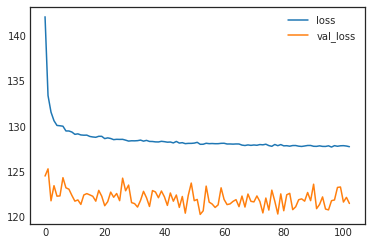

In [64]:
neurons_base = 8
l2_reg_rate = 0.3

model_snn4 = Sequential([
    tf.keras.layers.Dense(units=neurons_base*4, activation="selu", kernel_initializer="lecun_normal", 
                          kernel_regularizer=tf.keras.regularizers.l2(l=l2_reg_rate), input_shape=X_train.shape[1:]),
    tf.keras.layers.Dense(units=neurons_base*2, activation="selu", kernel_initializer="lecun_normal",
                         kernel_regularizer=tf.keras.regularizers.l2(l=l2_reg_rate)),
    tf.keras.layers.Dense(units=neurons_base, activation="selu", kernel_initializer="lecun_normal",
                         kernel_regularizer=tf.keras.regularizers.l2(l=l2_reg_rate)),
    tf.keras.layers.Dense(units=neurons_base/2, activation="selu", kernel_initializer="lecun_normal",
                         kernel_regularizer=tf.keras.regularizers.l2(l=l2_reg_rate)),
    Dense(1)])

print(model_snn4.count_params())

# snn: 32-16-8-4 with 30%l2 reg seems to converge to 5.1% test r2.

time1 = time.time()
model_snn4.compile(loss= "mean_squared_error" , optimizer=optimizer_adam, metrics=["mean_squared_error"])
history = model_snn4.fit(X_train, y_train, validation_data=(X_val, y_val), 
                         batch_size=2048, epochs=1000, verbose=2, callbacks=[early_stopping50])
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()))

print([r2_score(y_train, model_snn4.predict(X_train)), 
       r2_score(y_val, model_snn4.predict(X_val)),
       r2_score(y_test, model_snn4.predict(X_test))])
print(time.time()-time1)

results.loc[results.min_prd==min_prd,'nn4_train':'nn4_test'] = \
[r2_score(y_train, model_snn4.predict(X_train)), 
r2_score(y_val, model_snn4.predict(X_val)),
r2_score(y_test, model_snn4.predict(X_test))]

In [67]:
# try optuna, using this kaggle notebook: https://www.kaggle.com/code/mistag/keras-model-tuning-with-optuna

time1 = time.time()

trials = 50

def create_snnn_model_hyperpars(neurons_base=4, l2_reg_rate=0.1):

    model_snn = Sequential([
        tf.keras.layers.Dense(units=neurons_base*4, activation="selu", kernel_initializer="lecun_normal", 
                              kernel_regularizer=tf.keras.regularizers.l2(l=l2_reg_rate), input_shape=X_train.shape[1:]),
        tf.keras.layers.Dense(units=neurons_base*2, activation="selu", kernel_initializer="lecun_normal",
                             kernel_regularizer=tf.keras.regularizers.l2(l=l2_reg_rate)),
        tf.keras.layers.Dense(units=neurons_base, activation="selu", kernel_initializer="lecun_normal",
                             kernel_regularizer=tf.keras.regularizers.l2(l=l2_reg_rate)),
        tf.keras.layers.Dense(units=neurons_base/2, activation="selu", kernel_initializer="lecun_normal",
                             kernel_regularizer=tf.keras.regularizers.l2(l=l2_reg_rate)),
        Dense(1)])

    optimizer_adam = tf.keras.optimizers.Adam()
    model_snn.compile(loss= "mean_squared_error" , optimizer=optimizer_adam, metrics=["mean_squared_error"])
    
    return model_snn

def create_snnn_model(trial):

    # hyperparameter space
    neurons_base = trial.suggest_int("neurons_base", 4, 24, 2)
    l2_reg_rate = trial.suggest_float('l2_regularizer', 0, 0.9)

    model_snn = Sequential([
        tf.keras.layers.Dense(units=neurons_base*4, activation="selu", kernel_initializer="lecun_normal", 
                              kernel_regularizer=tf.keras.regularizers.l2(l=l2_reg_rate), input_shape=X_train.shape[1:]),
        tf.keras.layers.Dense(units=neurons_base*2, activation="selu", kernel_initializer="lecun_normal",
                             kernel_regularizer=tf.keras.regularizers.l2(l=l2_reg_rate)),
        tf.keras.layers.Dense(units=neurons_base, activation="selu", kernel_initializer="lecun_normal",
                             kernel_regularizer=tf.keras.regularizers.l2(l=l2_reg_rate)),
        tf.keras.layers.Dense(units=neurons_base/2, activation="selu", kernel_initializer="lecun_normal",
                             kernel_regularizer=tf.keras.regularizers.l2(l=l2_reg_rate)),
        Dense(1)])

    optimizer_adam = tf.keras.optimizers.Adam()
    model_snn.compile(loss= "mean_squared_error" , optimizer=optimizer_adam, metrics=["mean_squared_error"])
    
    return model_snn

    
EPOCHS = 10 # number of epocs per trial

def objective(trial):
    
    tf.keras.backend.clear_session()
    
    with strategy.scope():
        # Generate our trial model.
        model = create_snnn_model(trial)

        callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=40),
        TFKerasPruningCallback(trial, "val_loss"),
    ]

        # Fit the model on the training data.
        # The TFKerasPruningCallback checks for pruning condition every epoch.
        
        history = model.fit(X_train, y_train, 
                                validation_data=(X_val, y_val),
                                batch_size=2048, 
                                epochs=500, 
                                verbose=1, 
                                callbacks=callbacks)

        # Evaluate the model accuracy on the validation set.
        score = model.evaluate(X_val, y_val, verbose=0)
        return score[1]
    
study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(), pruner=optuna.pruners.HyperbandPruner())
study.optimize(objective, n_trials=trials)
pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])
temp = study.best_params
display(study.best_params, time.time()-time1)

[I 2022-09-07 22:49:42,936] A new study created in memory with name: no-name-f3ca1d1b-cdc6-4365-980d-d9a9b08a2f57


Epoch 1/500
39/39 [==============================] - 1s 9ms/step - loss: 209.5799 - mean_squared_error: 134.7092 - val_loss: 179.4044 - val_mean_squared_error: 120.8278
Epoch 2/500
39/39 [==============================] - 0s 4ms/step - loss: 180.7756 - mean_squared_error: 133.4974 - val_loss: 158.1037 - val_mean_squared_error: 121.0831
Epoch 3/500
39/39 [==============================] - 0s 4ms/step - loss: 163.2286 - mean_squared_error: 133.0988 - val_loss: 144.6748 - val_mean_squared_error: 120.7529
Epoch 4/500
39/39 [==============================] - 0s 4ms/step - loss: 152.4038 - mean_squared_error: 132.6337 - val_loss: 137.0984 - val_mean_squared_error: 121.0054
Epoch 5/500
39/39 [==============================] - 0s 4ms/step - loss: 145.6430 - mean_squared_error: 131.9883 - val_loss: 131.8617 - val_mean_squared_error: 120.3786
Epoch 6/500
39/39 [==============================] - 0s 4ms/step - loss: 141.2284 - mean_squared_error: 131.0718 - val_loss: 128.7828 - val_mean_squared_er

[I 2022-09-07 22:50:25,100] Trial 0 finished with value: 120.56806182861328 and parameters: {'neurons_base': 14, 'l2_regularizer': 0.8786922469367984}. Best is trial 0 with value: 120.56806182861328.


Epoch 1/500
39/39 [==============================] - 1s 8ms/step - loss: 194.6396 - mean_squared_error: 134.4987 - val_loss: 167.9107 - val_mean_squared_error: 121.3068
Epoch 2/500
39/39 [==============================] - 0s 4ms/step - loss: 170.4848 - mean_squared_error: 133.1645 - val_loss: 149.3508 - val_mean_squared_error: 120.4572
Epoch 3/500
39/39 [==============================] - 0s 4ms/step - loss: 155.8665 - mean_squared_error: 132.3676 - val_loss: 138.9509 - val_mean_squared_error: 120.2947
Epoch 4/500
39/39 [==============================] - 0s 4ms/step - loss: 146.5962 - mean_squared_error: 130.9197 - val_loss: 134.1755 - val_mean_squared_error: 120.9879
Epoch 5/500
39/39 [==============================] - 0s 4ms/step - loss: 140.7258 - mean_squared_error: 129.1246 - val_loss: 131.7939 - val_mean_squared_error: 121.6862
Epoch 6/500
39/39 [==============================] - 0s 4ms/step - loss: 137.1109 - mean_squared_error: 128.1500 - val_loss: 128.4175 - val_mean_squared_er

[I 2022-09-07 22:50:45,162] Trial 1 finished with value: 119.34262084960938 and parameters: {'neurons_base': 20, 'l2_regularizer': 0.4967091804297235}. Best is trial 1 with value: 119.34262084960938.


Epoch 1/500
39/39 [==============================] - 1s 8ms/step - loss: 139.9247 - mean_squared_error: 134.6290 - val_loss: 126.4963 - val_mean_squared_error: 121.6918
Epoch 2/500
39/39 [==============================] - 0s 4ms/step - loss: 136.8692 - mean_squared_error: 132.4005 - val_loss: 124.9675 - val_mean_squared_error: 120.7806
Epoch 3/500
39/39 [==============================] - 0s 4ms/step - loss: 133.7848 - mean_squared_error: 129.7185 - val_loss: 124.3953 - val_mean_squared_error: 120.4099
Epoch 4/500
39/39 [==============================] - 0s 4ms/step - loss: 131.6742 - mean_squared_error: 127.7797 - val_loss: 124.7098 - val_mean_squared_error: 120.9366
Epoch 5/500
39/39 [==============================] - 0s 4ms/step - loss: 130.7825 - mean_squared_error: 127.1335 - val_loss: 124.8136 - val_mean_squared_error: 121.2990
Epoch 6/500
39/39 [==============================] - 0s 7ms/step - loss: 130.4248 - mean_squared_error: 127.0202 - val_loss: 124.3721 - val_mean_squared_er

[I 2022-09-07 22:51:06,665] Trial 2 finished with value: 121.16156005859375 and parameters: {'neurons_base': 14, 'l2_regularizer': 0.05674735186433363}. Best is trial 1 with value: 119.34262084960938.


Epoch 1/500
39/39 [==============================] - 1s 8ms/step - loss: 159.7746 - mean_squared_error: 134.7816 - val_loss: 141.6109 - val_mean_squared_error: 121.0282
Epoch 2/500
39/39 [==============================] - 0s 4ms/step - loss: 150.9430 - mean_squared_error: 133.5240 - val_loss: 135.3512 - val_mean_squared_error: 120.8724
Epoch 3/500
39/39 [==============================] - 0s 4ms/step - loss: 145.2788 - mean_squared_error: 132.8012 - val_loss: 131.4358 - val_mean_squared_error: 120.7886
Epoch 4/500
39/39 [==============================] - 0s 4ms/step - loss: 141.4245 - mean_squared_error: 131.9476 - val_loss: 128.9291 - val_mean_squared_error: 120.4858
Epoch 5/500
39/39 [==============================] - 0s 4ms/step - loss: 138.5995 - mean_squared_error: 130.7409 - val_loss: 127.6894 - val_mean_squared_error: 120.3816
Epoch 6/500
39/39 [==============================] - 0s 4ms/step - loss: 136.3660 - mean_squared_error: 129.4111 - val_loss: 126.1381 - val_mean_squared_er

[I 2022-09-07 22:51:27,427] Trial 3 finished with value: 120.14647674560547 and parameters: {'neurons_base': 8, 'l2_regularizer': 0.49804382052762136}. Best is trial 1 with value: 119.34262084960938.


Epoch 1/500
39/39 [==============================] - 1s 9ms/step - loss: 167.3514 - mean_squared_error: 133.7534 - val_loss: 149.3967 - val_mean_squared_error: 121.5119
Epoch 2/500
39/39 [==============================] - 0s 4ms/step - loss: 155.7710 - mean_squared_error: 131.9993 - val_loss: 141.7130 - val_mean_squared_error: 121.7082


[I 2022-09-07 22:51:28,587] Trial 4 pruned. Trial was pruned at epoch 1.


Epoch 1/500
39/39 [==============================] - 1s 9ms/step - loss: 188.9071 - mean_squared_error: 135.1130 - val_loss: 161.2016 - val_mean_squared_error: 119.7686
Epoch 2/500
39/39 [==============================] - 0s 4ms/step - loss: 167.1558 - mean_squared_error: 134.0210 - val_loss: 146.1855 - val_mean_squared_error: 120.4262


[I 2022-09-07 22:51:29,839] Trial 5 pruned. Trial was pruned at epoch 1.


Epoch 1/500
39/39 [==============================] - 2s 10ms/step - loss: 143.5642 - mean_squared_error: 135.0594 - val_loss: 128.0921 - val_mean_squared_error: 120.5055
Epoch 2/500
39/39 [==============================] - 0s 4ms/step - loss: 140.0120 - mean_squared_error: 133.1121 - val_loss: 127.6764 - val_mean_squared_error: 121.4149
Epoch 3/500
39/39 [==============================] - 0s 4ms/step - loss: 137.6827 - mean_squared_error: 131.8404 - val_loss: 126.9001 - val_mean_squared_error: 121.4223
Epoch 4/500
39/39 [==============================] - 0s 4ms/step - loss: 135.4796 - mean_squared_error: 130.2100 - val_loss: 125.4245 - val_mean_squared_error: 120.3053
Epoch 5/500
39/39 [==============================] - 0s 4ms/step - loss: 133.5436 - mean_squared_error: 128.5322 - val_loss: 125.0243 - val_mean_squared_error: 120.1400
Epoch 6/500
39/39 [==============================] - 0s 4ms/step - loss: 132.5533 - mean_squared_error: 127.8442 - val_loss: 125.4379 - val_mean_squared_e

[I 2022-09-07 22:51:32,935] Trial 6 pruned. Trial was pruned at epoch 9.


Epoch 1/500
39/39 [==============================] - 1s 13ms/step - loss: 161.3870 - mean_squared_error: 134.0005 - val_loss: 144.1119 - val_mean_squared_error: 121.1072
Epoch 2/500
39/39 [==============================] - 0s 4ms/step - loss: 151.8315 - mean_squared_error: 131.9852 - val_loss: 138.1690 - val_mean_squared_error: 121.1831
Epoch 3/500
39/39 [==============================] - 0s 4ms/step - loss: 145.1184 - mean_squared_error: 130.0395 - val_loss: 132.8347 - val_mean_squared_error: 119.4777
Epoch 4/500
39/39 [==============================] - 0s 4ms/step - loss: 140.6441 - mean_squared_error: 128.5421 - val_loss: 130.8500 - val_mean_squared_error: 119.9493
Epoch 5/500
39/39 [==============================] - 0s 4ms/step - loss: 137.7228 - mean_squared_error: 127.7974 - val_loss: 129.1277 - val_mean_squared_error: 120.1268
Epoch 6/500
39/39 [==============================] - 0s 4ms/step - loss: 135.9709 - mean_squared_error: 127.6802 - val_loss: 126.6375 - val_mean_squared_e

[I 2022-09-07 22:51:35,706] Trial 7 pruned. Trial was pruned at epoch 9.


Epoch 1/500
39/39 [==============================] - 1s 9ms/step - loss: 153.4090 - mean_squared_error: 135.0367 - val_loss: 136.6386 - val_mean_squared_error: 121.1570
Epoch 2/500
39/39 [==============================] - 0s 4ms/step - loss: 147.3977 - mean_squared_error: 133.9859 - val_loss: 132.6352 - val_mean_squared_error: 121.1625
Epoch 3/500
39/39 [==============================] - 0s 4ms/step - loss: 143.5951 - mean_squared_error: 133.4696 - val_loss: 129.5720 - val_mean_squared_error: 120.6730
Epoch 4/500
39/39 [==============================] - 0s 4ms/step - loss: 141.0164 - mean_squared_error: 132.9779 - val_loss: 127.7042 - val_mean_squared_error: 120.4295
Epoch 5/500
39/39 [==============================] - 0s 4ms/step - loss: 139.2070 - mean_squared_error: 132.4295 - val_loss: 126.1406 - val_mean_squared_error: 119.8382
Epoch 6/500
39/39 [==============================] - 0s 4ms/step - loss: 137.8467 - mean_squared_error: 131.8452 - val_loss: 125.8541 - val_mean_squared_er

[I 2022-09-07 22:51:38,249] Trial 8 pruned. Trial was pruned at epoch 9.


Epoch 1/500
39/39 [==============================] - 1s 8ms/step - loss: 231.8262 - mean_squared_error: 134.2831 - val_loss: 195.0491 - val_mean_squared_error: 121.4573
Epoch 2/500
39/39 [==============================] - 0s 4ms/step - loss: 190.7276 - mean_squared_error: 133.1104 - val_loss: 164.9107 - val_mean_squared_error: 121.4722
Epoch 3/500
39/39 [==============================] - 0s 4ms/step - loss: 166.5779 - mean_squared_error: 132.2139 - val_loss: 146.6839 - val_mean_squared_error: 120.3726
Epoch 4/500
39/39 [==============================] - 0s 4ms/step - loss: 152.4561 - mean_squared_error: 131.0742 - val_loss: 136.5134 - val_mean_squared_error: 119.4466
Epoch 5/500
39/39 [==============================] - 0s 4ms/step - loss: 144.0632 - mean_squared_error: 129.6766 - val_loss: 130.6054 - val_mean_squared_error: 118.6494
Epoch 6/500
39/39 [==============================] - 0s 4ms/step - loss: 139.1175 - mean_squared_error: 128.7442 - val_loss: 130.3951 - val_mean_squared_er

[I 2022-09-07 22:51:59,704] Trial 9 finished with value: 119.35317993164062 and parameters: {'neurons_base': 24, 'l2_regularizer': 0.6874449374411037}. Best is trial 1 with value: 119.34262084960938.


Epoch 1/500
39/39 [==============================] - 1s 8ms/step - loss: 170.5536 - mean_squared_error: 135.3804 - val_loss: 148.5461 - val_mean_squared_error: 119.8305
Epoch 2/500
39/39 [==============================] - 0s 4ms/step - loss: 158.1410 - mean_squared_error: 134.0225 - val_loss: 139.9199 - val_mean_squared_error: 120.0713


[I 2022-09-07 22:52:00,832] Trial 10 pruned. Trial was pruned at epoch 1.


Epoch 1/500
39/39 [==============================] - 1s 8ms/step - loss: 157.4785 - mean_squared_error: 133.9189 - val_loss: 141.0265 - val_mean_squared_error: 121.0304
Epoch 2/500
39/39 [==============================] - 0s 4ms/step - loss: 148.7290 - mean_squared_error: 131.2623 - val_loss: 135.3117 - val_mean_squared_error: 120.0936
Epoch 3/500
39/39 [==============================] - 0s 4ms/step - loss: 142.3446 - mean_squared_error: 128.5480 - val_loss: 133.6474 - val_mean_squared_error: 121.2154
Epoch 4/500
39/39 [==============================] - 0s 4ms/step - loss: 138.8680 - mean_squared_error: 127.5104 - val_loss: 132.6227 - val_mean_squared_error: 122.3389


[I 2022-09-07 22:52:02,375] Trial 11 pruned. Trial was pruned at epoch 3.


Epoch 1/500
39/39 [==============================] - 1s 8ms/step - loss: 156.2511 - mean_squared_error: 134.3880 - val_loss: 140.1546 - val_mean_squared_error: 121.7292
Epoch 2/500
39/39 [==============================] - 0s 5ms/step - loss: 148.4823 - mean_squared_error: 132.5291 - val_loss: 134.7788 - val_mean_squared_error: 121.0920
Epoch 3/500
39/39 [==============================] - 0s 4ms/step - loss: 142.8564 - mean_squared_error: 130.6349 - val_loss: 131.8465 - val_mean_squared_error: 120.9149
Epoch 4/500
39/39 [==============================] - 0s 6ms/step - loss: 138.7733 - mean_squared_error: 128.7037 - val_loss: 129.6133 - val_mean_squared_error: 120.4509
Epoch 5/500
39/39 [==============================] - 0s 6ms/step - loss: 136.2266 - mean_squared_error: 127.8006 - val_loss: 128.9430 - val_mean_squared_error: 121.2117
Epoch 6/500
39/39 [==============================] - 0s 5ms/step - loss: 134.8186 - mean_squared_error: 127.6328 - val_loss: 125.8913 - val_mean_squared_er

[I 2022-09-07 22:52:05,002] Trial 12 pruned. Trial was pruned at epoch 9.


Epoch 1/500
39/39 [==============================] - 1s 8ms/step - loss: 155.3535 - mean_squared_error: 135.0871 - val_loss: 138.1504 - val_mean_squared_error: 120.8910
Epoch 2/500
39/39 [==============================] - 0s 4ms/step - loss: 148.3266 - mean_squared_error: 133.2770 - val_loss: 134.1863 - val_mean_squared_error: 121.2111
Epoch 3/500
39/39 [==============================] - 0s 4ms/step - loss: 143.7629 - mean_squared_error: 132.2307 - val_loss: 131.3358 - val_mean_squared_error: 121.1103
Epoch 4/500
39/39 [==============================] - 0s 4ms/step - loss: 140.2065 - mean_squared_error: 130.8232 - val_loss: 128.5503 - val_mean_squared_error: 119.9026
Epoch 5/500
39/39 [==============================] - 0s 7ms/step - loss: 137.4956 - mean_squared_error: 129.3660 - val_loss: 127.7399 - val_mean_squared_error: 120.1241
Epoch 6/500
39/39 [==============================] - 0s 6ms/step - loss: 135.7381 - mean_squared_error: 128.5662 - val_loss: 126.5329 - val_mean_squared_er

[I 2022-09-07 22:52:18,903] Trial 13 pruned. Trial was pruned at epoch 81.


Epoch 1/500
39/39 [==============================] - 1s 8ms/step - loss: 140.9089 - mean_squared_error: 135.4829 - val_loss: 124.8271 - val_mean_squared_error: 119.8828
Epoch 2/500
39/39 [==============================] - 0s 4ms/step - loss: 138.4914 - mean_squared_error: 133.9093 - val_loss: 124.8847 - val_mean_squared_error: 120.6315
Epoch 3/500
39/39 [==============================] - 0s 4ms/step - loss: 136.8657 - mean_squared_error: 132.8407 - val_loss: 124.2650 - val_mean_squared_error: 120.4273
Epoch 4/500
39/39 [==============================] - 0s 4ms/step - loss: 135.2872 - mean_squared_error: 131.5340 - val_loss: 123.2606 - val_mean_squared_error: 119.5538
Epoch 5/500
39/39 [==============================] - 0s 6ms/step - loss: 133.6771 - mean_squared_error: 129.9609 - val_loss: 123.3747 - val_mean_squared_error: 119.6427
Epoch 6/500
39/39 [==============================] - 0s 5ms/step - loss: 132.4991 - mean_squared_error: 128.7741 - val_loss: 122.2551 - val_mean_squared_er

[I 2022-09-07 22:52:55,742] Trial 14 finished with value: 120.61849212646484 and parameters: {'neurons_base': 4, 'l2_regularizer': 0.1950751966223698}. Best is trial 1 with value: 119.34262084960938.


Epoch 1/500
39/39 [==============================] - 1s 8ms/step - loss: 186.4751 - mean_squared_error: 135.3347 - val_loss: 163.9884 - val_mean_squared_error: 122.1435
Epoch 2/500
39/39 [==============================] - 0s 4ms/step - loss: 168.1543 - mean_squared_error: 133.2033 - val_loss: 149.9768 - val_mean_squared_error: 121.3649
Epoch 3/500
39/39 [==============================] - 0s 4ms/step - loss: 156.7344 - mean_squared_error: 132.4803 - val_loss: 141.4876 - val_mean_squared_error: 121.2572
Epoch 4/500
39/39 [==============================] - 0s 4ms/step - loss: 149.3036 - mean_squared_error: 131.8657 - val_loss: 135.1328 - val_mean_squared_error: 120.2312
Epoch 5/500
39/39 [==============================] - 0s 4ms/step - loss: 144.3267 - mean_squared_error: 131.0919 - val_loss: 132.1594 - val_mean_squared_error: 120.4736
Epoch 6/500
39/39 [==============================] - 0s 4ms/step - loss: 140.8563 - mean_squared_error: 130.2028 - val_loss: 131.5762 - val_mean_squared_er

[I 2022-09-07 22:53:01,049] Trial 15 pruned. Trial was pruned at epoch 27.


Epoch 1/500
39/39 [==============================] - 1s 10ms/step - loss: 196.9398 - mean_squared_error: 135.4412 - val_loss: 168.4488 - val_mean_squared_error: 120.1472
Epoch 2/500
39/39 [==============================] - 0s 4ms/step - loss: 173.3701 - mean_squared_error: 134.1732 - val_loss: 151.1399 - val_mean_squared_error: 120.2220


[I 2022-09-07 22:53:02,289] Trial 16 pruned. Trial was pruned at epoch 1.


Epoch 1/500
39/39 [==============================] - 1s 8ms/step - loss: 149.9014 - mean_squared_error: 134.9927 - val_loss: 133.4051 - val_mean_squared_error: 120.8493
Epoch 2/500
39/39 [==============================] - 0s 4ms/step - loss: 144.6937 - mean_squared_error: 133.8565 - val_loss: 130.2226 - val_mean_squared_error: 120.9956
Epoch 3/500
39/39 [==============================] - 0s 4ms/step - loss: 141.3558 - mean_squared_error: 133.2075 - val_loss: 127.7949 - val_mean_squared_error: 120.6242
Epoch 4/500
39/39 [==============================] - 0s 4ms/step - loss: 138.8738 - mean_squared_error: 132.3111 - val_loss: 126.5521 - val_mean_squared_error: 120.5007
Epoch 5/500
39/39 [==============================] - 0s 4ms/step - loss: 136.8105 - mean_squared_error: 131.0145 - val_loss: 125.9898 - val_mean_squared_error: 120.3706
Epoch 6/500
39/39 [==============================] - 0s 4ms/step - loss: 134.9754 - mean_squared_error: 129.4147 - val_loss: 124.6710 - val_mean_squared_er

[I 2022-09-07 22:53:04,661] Trial 17 pruned. Trial was pruned at epoch 9.


Epoch 1/500
39/39 [==============================] - 1s 8ms/step - loss: 149.7721 - mean_squared_error: 134.7000 - val_loss: 134.0710 - val_mean_squared_error: 121.3606
Epoch 2/500
39/39 [==============================] - 0s 4ms/step - loss: 143.6948 - mean_squared_error: 132.6433 - val_loss: 131.1103 - val_mean_squared_error: 121.5431
Epoch 3/500
39/39 [==============================] - 0s 4ms/step - loss: 139.1776 - mean_squared_error: 130.4939 - val_loss: 128.3839 - val_mean_squared_error: 120.4005
Epoch 4/500
39/39 [==============================] - 0s 4ms/step - loss: 135.7581 - mean_squared_error: 128.2504 - val_loss: 128.4682 - val_mean_squared_error: 121.4887


[I 2022-09-07 22:53:06,930] Trial 18 pruned. Trial was pruned at epoch 3.


Epoch 1/500
39/39 [==============================] - 1s 8ms/step - loss: 161.1411 - mean_squared_error: 136.6601 - val_loss: 140.5852 - val_mean_squared_error: 119.6440
Epoch 2/500
39/39 [==============================] - 0s 4ms/step - loss: 152.8132 - mean_squared_error: 134.5034 - val_loss: 135.8767 - val_mean_squared_error: 120.0562


[I 2022-09-07 22:53:08,625] Trial 19 pruned. Trial was pruned at epoch 1.


Epoch 1/500
39/39 [==============================] - 2s 29ms/step - loss: 165.6974 - mean_squared_error: 134.6034 - val_loss: 146.5969 - val_mean_squared_error: 121.2692
Epoch 2/500
39/39 [==============================] - 0s 7ms/step - loss: 154.6212 - mean_squared_error: 133.4446 - val_loss: 138.5368 - val_mean_squared_error: 121.1894


[I 2022-09-07 22:53:10,977] Trial 20 pruned. Trial was pruned at epoch 1.


Epoch 1/500
39/39 [==============================] - 1s 8ms/step - loss: 156.6392 - mean_squared_error: 135.7260 - val_loss: 136.5461 - val_mean_squared_error: 119.2220
Epoch 2/500
39/39 [==============================] - 0s 4ms/step - loss: 149.6866 - mean_squared_error: 134.8369 - val_loss: 132.3982 - val_mean_squared_error: 119.8295
Epoch 3/500
39/39 [==============================] - 0s 4ms/step - loss: 145.2049 - mean_squared_error: 134.2406 - val_loss: 129.5877 - val_mean_squared_error: 120.1187
Epoch 4/500
39/39 [==============================] - 0s 4ms/step - loss: 142.2552 - mean_squared_error: 133.8264 - val_loss: 127.9437 - val_mean_squared_error: 120.4591
Epoch 5/500
39/39 [==============================] - 0s 4ms/step - loss: 140.2557 - mean_squared_error: 133.4239 - val_loss: 126.5718 - val_mean_squared_error: 120.3966
Epoch 6/500
39/39 [==============================] - 0s 4ms/step - loss: 138.8603 - mean_squared_error: 133.1634 - val_loss: 125.3231 - val_mean_squared_er

[I 2022-09-07 22:53:14,439] Trial 21 pruned. Trial was pruned at epoch 9.


Epoch 1/500
39/39 [==============================] - 1s 8ms/step - loss: 147.7643 - mean_squared_error: 134.3405 - val_loss: 133.1967 - val_mean_squared_error: 121.3797
Epoch 2/500
39/39 [==============================] - 0s 4ms/step - loss: 142.6418 - mean_squared_error: 132.0168 - val_loss: 130.3910 - val_mean_squared_error: 120.8508
Epoch 3/500
39/39 [==============================] - 0s 4ms/step - loss: 138.8007 - mean_squared_error: 129.9418 - val_loss: 128.5319 - val_mean_squared_error: 120.2713
Epoch 4/500
39/39 [==============================] - 0s 4ms/step - loss: 135.8402 - mean_squared_error: 128.0533 - val_loss: 128.2366 - val_mean_squared_error: 120.9443


[I 2022-09-07 22:53:16,450] Trial 22 pruned. Trial was pruned at epoch 3.


Epoch 1/500
39/39 [==============================] - 1s 8ms/step - loss: 195.8515 - mean_squared_error: 134.4650 - val_loss: 168.9264 - val_mean_squared_error: 121.6720
Epoch 2/500
39/39 [==============================] - 0s 4ms/step - loss: 170.8463 - mean_squared_error: 133.1575 - val_loss: 149.7794 - val_mean_squared_error: 120.6415


[I 2022-09-07 22:53:18,061] Trial 23 pruned. Trial was pruned at epoch 1.


Epoch 1/500
39/39 [==============================] - 1s 8ms/step - loss: 176.5991 - mean_squared_error: 135.3127 - val_loss: 153.8296 - val_mean_squared_error: 120.7977
Epoch 2/500
39/39 [==============================] - 0s 4ms/step - loss: 161.1699 - mean_squared_error: 133.8914 - val_loss: 143.4227 - val_mean_squared_error: 121.4041


[I 2022-09-07 22:53:19,184] Trial 24 pruned. Trial was pruned at epoch 1.


Epoch 1/500
39/39 [==============================] - 1s 8ms/step - loss: 206.9316 - mean_squared_error: 134.0067 - val_loss: 180.3037 - val_mean_squared_error: 122.0333
Epoch 2/500
39/39 [==============================] - 0s 4ms/step - loss: 180.1041 - mean_squared_error: 132.2355 - val_loss: 159.3341 - val_mean_squared_error: 120.9980
Epoch 3/500
39/39 [==============================] - 0s 4ms/step - loss: 162.7852 - mean_squared_error: 130.8055 - val_loss: 146.1253 - val_mean_squared_error: 119.8481
Epoch 4/500
39/39 [==============================] - 0s 4ms/step - loss: 151.7788 - mean_squared_error: 129.2885 - val_loss: 139.9922 - val_mean_squared_error: 121.0586
Epoch 5/500
39/39 [==============================] - 0s 4ms/step - loss: 144.9531 - mean_squared_error: 128.4741 - val_loss: 135.4672 - val_mean_squared_error: 121.3572
Epoch 6/500
39/39 [==============================] - 0s 8ms/step - loss: 140.5443 - mean_squared_error: 128.0632 - val_loss: 131.1838 - val_mean_squared_er

[I 2022-09-07 22:53:22,021] Trial 25 pruned. Trial was pruned at epoch 9.


Epoch 1/500
39/39 [==============================] - 1s 8ms/step - loss: 165.4612 - mean_squared_error: 133.9987 - val_loss: 147.5480 - val_mean_squared_error: 121.5530
Epoch 2/500
39/39 [==============================] - 0s 4ms/step - loss: 154.6840 - mean_squared_error: 132.6138 - val_loss: 139.9175 - val_mean_squared_error: 121.4135
Epoch 3/500
39/39 [==============================] - 0s 4ms/step - loss: 147.4825 - mean_squared_error: 131.4306 - val_loss: 134.8849 - val_mean_squared_error: 121.0161
Epoch 4/500
39/39 [==============================] - 0s 5ms/step - loss: 142.2059 - mean_squared_error: 129.7219 - val_loss: 131.1270 - val_mean_squared_error: 119.9305


[I 2022-09-07 22:53:23,873] Trial 26 pruned. Trial was pruned at epoch 3.


Epoch 1/500
39/39 [==============================] - 1s 8ms/step - loss: 187.5886 - mean_squared_error: 135.1090 - val_loss: 162.3654 - val_mean_squared_error: 120.5592
Epoch 2/500
39/39 [==============================] - 0s 4ms/step - loss: 167.7466 - mean_squared_error: 133.4923 - val_loss: 148.4574 - val_mean_squared_error: 121.1060
Epoch 3/500
39/39 [==============================] - 0s 4ms/step - loss: 155.4313 - mean_squared_error: 132.7393 - val_loss: 139.2735 - val_mean_squared_error: 120.7773
Epoch 4/500
39/39 [==============================] - 0s 4ms/step - loss: 147.4636 - mean_squared_error: 131.6861 - val_loss: 133.9359 - val_mean_squared_error: 120.5810


[I 2022-09-07 22:53:25,289] Trial 27 pruned. Trial was pruned at epoch 3.


Epoch 1/500
39/39 [==============================] - 1s 8ms/step - loss: 173.9600 - mean_squared_error: 134.2812 - val_loss: 153.0872 - val_mean_squared_error: 121.8697
Epoch 2/500
39/39 [==============================] - 0s 4ms/step - loss: 158.3149 - mean_squared_error: 132.8521 - val_loss: 141.4816 - val_mean_squared_error: 121.1650


[I 2022-09-07 22:53:26,422] Trial 28 pruned. Trial was pruned at epoch 1.


Epoch 1/500
39/39 [==============================] - 1s 8ms/step - loss: 138.2689 - mean_squared_error: 132.9238 - val_loss: 126.2686 - val_mean_squared_error: 121.1430
Epoch 2/500
39/39 [==============================] - 0s 4ms/step - loss: 134.0459 - mean_squared_error: 129.0565 - val_loss: 128.1798 - val_mean_squared_error: 123.3067
Epoch 3/500
39/39 [==============================] - 0s 4ms/step - loss: 132.1286 - mean_squared_error: 127.3687 - val_loss: 128.2809 - val_mean_squared_error: 123.6413
Epoch 4/500
39/39 [==============================] - 0s 4ms/step - loss: 131.4993 - mean_squared_error: 126.9735 - val_loss: 124.6939 - val_mean_squared_error: 120.2778
Epoch 5/500
39/39 [==============================] - 0s 4ms/step - loss: 130.9945 - mean_squared_error: 126.6735 - val_loss: 123.3370 - val_mean_squared_error: 119.1197
Epoch 6/500
39/39 [==============================] - 0s 4ms/step - loss: 130.5773 - mean_squared_error: 126.4465 - val_loss: 125.5090 - val_mean_squared_er

[I 2022-09-07 22:53:31,495] Trial 29 pruned. Trial was pruned at epoch 27.


Epoch 1/500
39/39 [==============================] - 1s 8ms/step - loss: 216.1007 - mean_squared_error: 134.6375 - val_loss: 183.7370 - val_mean_squared_error: 121.0137
Epoch 2/500
39/39 [==============================] - 0s 4ms/step - loss: 183.2911 - mean_squared_error: 133.3227 - val_loss: 159.3273 - val_mean_squared_error: 120.8695
Epoch 3/500
39/39 [==============================] - 0s 4ms/step - loss: 163.4590 - mean_squared_error: 132.5285 - val_loss: 145.3781 - val_mean_squared_error: 121.1850
Epoch 4/500
39/39 [==============================] - 0s 4ms/step - loss: 151.3700 - mean_squared_error: 131.4205 - val_loss: 135.7501 - val_mean_squared_error: 119.5075


[I 2022-09-07 22:53:33,591] Trial 30 pruned. Trial was pruned at epoch 3.


Epoch 1/500
39/39 [==============================] - 1s 8ms/step - loss: 156.8799 - mean_squared_error: 136.2086 - val_loss: 137.6923 - val_mean_squared_error: 120.0518
Epoch 2/500
39/39 [==============================] - 0s 4ms/step - loss: 149.5651 - mean_squared_error: 134.1058 - val_loss: 134.7141 - val_mean_squared_error: 121.2912
Epoch 3/500
39/39 [==============================] - 0s 4ms/step - loss: 145.3614 - mean_squared_error: 133.4164 - val_loss: 131.5986 - val_mean_squared_error: 121.0365
Epoch 4/500
39/39 [==============================] - 0s 4ms/step - loss: 142.4982 - mean_squared_error: 132.9112 - val_loss: 129.3479 - val_mean_squared_error: 120.6845


[I 2022-09-07 22:53:35,517] Trial 31 pruned. Trial was pruned at epoch 3.


Epoch 1/500
39/39 [==============================] - 1s 9ms/step - loss: 164.4267 - mean_squared_error: 134.8257 - val_loss: 144.4337 - val_mean_squared_error: 120.3162
Epoch 2/500
39/39 [==============================] - 0s 4ms/step - loss: 153.7018 - mean_squared_error: 133.5132 - val_loss: 137.1955 - val_mean_squared_error: 120.6660


[I 2022-09-07 22:53:37,090] Trial 32 pruned. Trial was pruned at epoch 1.


Epoch 1/500
39/39 [==============================] - 1s 8ms/step - loss: 163.4219 - mean_squared_error: 134.7158 - val_loss: 143.8367 - val_mean_squared_error: 120.3783
Epoch 2/500
39/39 [==============================] - 0s 4ms/step - loss: 153.4831 - mean_squared_error: 133.7570 - val_loss: 136.6693 - val_mean_squared_error: 120.3951


[I 2022-09-07 22:53:38,317] Trial 33 pruned. Trial was pruned at epoch 1.


Epoch 1/500
39/39 [==============================] - 1s 8ms/step - loss: 191.4130 - mean_squared_error: 134.2994 - val_loss: 166.8169 - val_mean_squared_error: 120.8813
Epoch 2/500
39/39 [==============================] - 0s 4ms/step - loss: 170.9529 - mean_squared_error: 133.0004 - val_loss: 151.3976 - val_mean_squared_error: 120.7801
Epoch 3/500
39/39 [==============================] - 0s 4ms/step - loss: 157.8620 - mean_squared_error: 132.2189 - val_loss: 142.2915 - val_mean_squared_error: 121.1750
Epoch 4/500
39/39 [==============================] - 0s 4ms/step - loss: 149.4949 - mean_squared_error: 131.3985 - val_loss: 136.1807 - val_mean_squared_error: 120.8192


[I 2022-09-07 22:53:39,856] Trial 34 pruned. Trial was pruned at epoch 3.


Epoch 1/500
39/39 [==============================] - 1s 10ms/step - loss: 210.6712 - mean_squared_error: 134.5149 - val_loss: 180.2592 - val_mean_squared_error: 120.3603
Epoch 2/500
39/39 [==============================] - 0s 6ms/step - loss: 181.8083 - mean_squared_error: 133.2255 - val_loss: 159.0371 - val_mean_squared_error: 120.7241


[I 2022-09-07 22:53:41,150] Trial 35 pruned. Trial was pruned at epoch 1.


Epoch 1/500
39/39 [==============================] - 1s 8ms/step - loss: 166.5448 - mean_squared_error: 134.8728 - val_loss: 147.4993 - val_mean_squared_error: 121.0803
Epoch 2/500
39/39 [==============================] - 0s 7ms/step - loss: 155.8964 - mean_squared_error: 133.3740 - val_loss: 140.2596 - val_mean_squared_error: 121.3869


[I 2022-09-07 22:53:42,987] Trial 36 pruned. Trial was pruned at epoch 1.


Epoch 1/500
39/39 [==============================] - 1s 8ms/step - loss: 140.2946 - mean_squared_error: 135.1239 - val_loss: 124.4622 - val_mean_squared_error: 119.8508
Epoch 2/500
39/39 [==============================] - 0s 4ms/step - loss: 138.1811 - mean_squared_error: 133.9850 - val_loss: 123.9499 - val_mean_squared_error: 120.1316
Epoch 3/500
39/39 [==============================] - 0s 4ms/step - loss: 136.7515 - mean_squared_error: 133.1839 - val_loss: 123.4743 - val_mean_squared_error: 120.1206
Epoch 4/500
39/39 [==============================] - 0s 4ms/step - loss: 135.4738 - mean_squared_error: 132.2266 - val_loss: 122.7818 - val_mean_squared_error: 119.6065
Epoch 5/500
39/39 [==============================] - 0s 4ms/step - loss: 134.1532 - mean_squared_error: 130.9902 - val_loss: 122.2048 - val_mean_squared_error: 119.0384
Epoch 6/500
39/39 [==============================] - 0s 4ms/step - loss: 132.9610 - mean_squared_error: 129.7871 - val_loss: 122.0561 - val_mean_squared_er

[I 2022-09-07 22:54:04,539] Trial 37 finished with value: 121.5654067993164 and parameters: {'neurons_base': 4, 'l2_regularizer': 0.18534764774614004}. Best is trial 1 with value: 119.34262084960938.


Epoch 1/500
39/39 [==============================] - 2s 9ms/step - loss: 165.1991 - mean_squared_error: 133.5409 - val_loss: 148.8527 - val_mean_squared_error: 122.0047
Epoch 2/500
39/39 [==============================] - 0s 4ms/step - loss: 154.8132 - mean_squared_error: 131.4026 - val_loss: 141.6765 - val_mean_squared_error: 121.3919
Epoch 3/500
39/39 [==============================] - 0s 4ms/step - loss: 147.3012 - mean_squared_error: 129.1156 - val_loss: 137.8113 - val_mean_squared_error: 121.5744
Epoch 4/500
39/39 [==============================] - 0s 4ms/step - loss: 142.5713 - mean_squared_error: 127.8608 - val_loss: 133.0085 - val_mean_squared_error: 119.8102


[I 2022-09-07 22:54:06,729] Trial 38 pruned. Trial was pruned at epoch 3.


Epoch 1/500
39/39 [==============================] - 1s 9ms/step - loss: 216.0493 - mean_squared_error: 134.5613 - val_loss: 184.7544 - val_mean_squared_error: 121.9480
Epoch 2/500
39/39 [==============================] - 0s 4ms/step - loss: 183.2891 - mean_squared_error: 133.2259 - val_loss: 159.8660 - val_mean_squared_error: 121.2225


[I 2022-09-07 22:54:07,870] Trial 39 pruned. Trial was pruned at epoch 1.


{'neurons_base': 20, 'l2_regularizer': 0.4967091804297235}

264.93879866600037

In [68]:
optimal_hyperpars = list(temp.values())
optimal_hyperpars

[20, 0.4967091804297235]

In [72]:
optuna_nn = create_snnn_model_hyperpars(neurons_base=optimal_hyperpars[0], l2_reg_rate=optimal_hyperpars[1])
history = optuna_nn.fit(X_train, y_train, 
                        validation_data=(X_val, y_val),
                        batch_size=2048, 
                        epochs=1000,
                        verbose=1, 
                        callbacks=[early_stopping50])

[r2_score(y_train, optuna_nn.predict(X_train)), 
r2_score(y_val, optuna_nn.predict(X_val)),
r2_score(y_test, optuna_nn.predict(X_test))]

results.loc[results.min_prd==min_prd,'nn4opt_train':'nn4opt_test'] = \
[r2_score(y_train, optuna_nn.predict(X_train)), 
r2_score(y_val, optuna_nn.predict(X_val)),
r2_score(y_test, optuna_nn.predict(X_test))]

Epoch 1/1000
39/39 [==============================] - 1s 8ms/step - loss: 194.2656 - mean_squared_error: 134.1888 - val_loss: 168.3116 - val_mean_squared_error: 121.0191
Epoch 2/1000
39/39 [==============================] - 0s 4ms/step - loss: 171.1103 - mean_squared_error: 132.6178 - val_loss: 151.0760 - val_mean_squared_error: 120.6060
Epoch 3/1000
39/39 [==============================] - 0s 4ms/step - loss: 156.5493 - mean_squared_error: 131.2391 - val_loss: 141.6954 - val_mean_squared_error: 120.8887
Epoch 4/1000
39/39 [==============================] - 0s 4ms/step - loss: 147.2362 - mean_squared_error: 129.3084 - val_loss: 136.2427 - val_mean_squared_error: 121.0957
Epoch 5/1000
39/39 [==============================] - 0s 4ms/step - loss: 141.5714 - mean_squared_error: 128.3591 - val_loss: 130.3520 - val_mean_squared_error: 118.9298
Epoch 6/1000
39/39 [==============================] - 0s 4ms/step - loss: 138.0432 - mean_squared_error: 127.9019 - val_loss: 128.9853 - val_mean_squa

In [73]:
display(time.time()-time0, results)

1705.343987941742

,min_prd,xgbf_train,xgbf_val,xgbf_test,xgbgs_train,xgbgs_val,xgbgs_test,xgbo_train,xgbo_val,xgbo_test,nn4_train,nn4_val,nn4_test,nn4opt_train,nn4opt_val,nn4opt_test
0,250,0.088074,-0.012211,0.015254,0.060695,0.032498,0.025239,0.079866,0.02653,0.027898,0.073775,-0.005649,0.014521,0.06939,0.008369,0.02173


In [20]:
# try optuna for NN:

def objective(trial):

    n_layers = trial.suggest_int('n_layers', 1, 3)
    model = tf.keras.Sequential()
    for i in range(n_layers):
        num_hidden = trial.suggest_int(f'n_units_l{i}', 4, 128, log=True)
        model.add(tf.keras.layers.Dense(num_hidden, activation='relu'))
    model.add(tf.keras.layers.Dense(1))
    display(model.summary())
    return accuracy

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)


[I 2022-09-07 22:03:28,634] A new study created in memory with name: no-name-eabf0cfc-87b5-4e10-9916-a287739dba76
[W 2022-09-07 22:03:28,642] Trial 0 failed because of the following error: ValueError('This model has not yet been built. Build the model first by calling `build()` or calling `fit()` with some data, or specify an `input_shape` argument in the first layer(s) for automatic build.')
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/optuna/study/_optimize.py", line 213, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_17/3767762731.py", line 11, in objective
    display(model.summary())
  File "/opt/conda/lib/python3.7/site-packages/keras/engine/training.py", line 2521, in summary
    raise ValueError('This model has not yet been built. '
ValueError: This model has not yet been built. Build the model first by calling `build()` or calling `fit()` with some data, or specify an `input_shape` argument in the first layer(s) for 

ValueError: This model has not yet been built. Build the model first by calling `build()` or calling `fit()` with some data, or specify an `input_shape` argument in the first layer(s) for automatic build.

In [ ]:
model_snn.summary()

In [ ]:
# on nns:
# - try classic regularizers (l1, l2 etc)
# - try different architecture (not snnn)
# classic architecture:
# He initialization, elu activation, batch norm, l2 reg, adam.

# - try exotic architecture, e.g., wide'n'deep
# 


In [ ]:
# usually self-norm seems better: it overfits less and runs faster

